In [ ]:
%cd ..

In [2]:
from typing import Union
from tqdm import tqdm
from statistics import mean
from pathlib import Path
import time

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision.models import alexnet, AlexNet_Weights

from conv_cp.imagenet.dataset import ImageNet

In [3]:
model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
model = model.cuda()
transform = AlexNet_Weights.IMAGENET1K_V1.transforms()

dataset = ImageNet(root_dir="data/val-images", transform=transform)
train_dataset, val_dataset = dataset.split(0.9)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [4]:
def select_correct_images(
    model: nn.Module, loader: DataLoader, amount: int = 512
) -> torch.Tensor:
    images = []
    cnt = 0
    for x, y in loader:
        x = x.to("cuda")
        y = y.to("cuda")
        with torch.no_grad():
            y_pred = model(x).argmax(dim=-1)
        ids = torch.where(y == y_pred)[0]
        cnt += len(ids)
        images.append(x[ids].cpu())
        if cnt >= amount:
            break

    images = torch.cat(images, dim=0)
    return images[:amount]

In [5]:
def acc_fn_1(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.argmax(dim=1)
    correct = (y_pred == y_true).sum().item()
    return correct / y_true.size(0)


def acc_fn_5(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.topk(5, dim=1).indices
    correct = (y_pred == y_true.unsqueeze(1)).sum().item()
    return correct / y_true.size(0)


def fgsm(
    model: nn.Module, imgs: torch.Tensor, labels: torch.Tensor, eps: float = 0.001
) -> float:
    for param in model.parameters():
        param.requires_grad = False

    step_counts = []
    loop = tqdm(range(len(imgs)), desc="FGSM")
    for i in loop:
        img = imgs[i].to("cuda")[None]
        label = labels[i].to("cuda")[None]

        for step in range(1000):
            img.requires_grad_(True)
            img.retain_grad()
            logits = model(img)
            if logits.argmax(dim=-1) != label:
                break

            loss = F.cross_entropy(logits, label)
            loss.backward()
            img = img + torch.sign(img.grad).detach() * eps
        if len(step_counts) > 0:
            loop.set_postfix(dict(resistance=sum(step_counts) / len(step_counts)))
        step_counts.append(step)

    return sum(step_counts) / len(step_counts)


def evaluate(
    model: nn.Module, dataloader: DataLoader, device: Union[str, torch.device]
):
    model.eval()
    model.to(device)
    accs = []
    accs_5 = []
    times = []
    loop = tqdm(dataloader, desc="Evaluation")
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            t_start = time.time()
            y_pred = model(x)
            times.append(time.time() - t_start)
            accs.append(acc_fn_1(y_pred, y))
            accs_5.append(acc_fn_5(y_pred, y))
            loop.set_postfix(acc=mean(accs), acc_5=mean(accs_5))
    return mean(accs), mean(accs_5), sum(times)

In [6]:
def get_adv_resistance(model: nn.Module, loader: DataLoader) -> float:
    imgs = select_correct_images(model, loader, 1000)
    with torch.no_grad():
        labels = []
        for idx in range(0, len(imgs), 256):
            imgs_batch = imgs[idx: idx + 256]
            labels.append(model(imgs_batch.to("cuda")).argmax(dim=-1))
        labels = torch.cat(labels, dim=0)
    
    return fgsm(model, imgs, labels, eps=0.001)

def get_model_size(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

In [7]:
results = []
_, _, inference_time = evaluate(model, val_loader, "cuda")
results.append(
    {
        "conv_rank": "full",
        "fc_rank": "full",
        "acc@1": 0.56522,
        "acc@5": 0.79066,
        "adv_resistance": get_adv_resistance(model, val_loader),
        "n_params": get_model_size(model),
        "inference_time": inference_time,
    }
)

model = model.cpu()
del model

for checkpoint_path in Path("checkpoints").iterdir():
    checkpoint_name = checkpoint_path.stem
    print(f"Processing {checkpoint_name}")
    model = torch.load(checkpoint_path, weights_only=False).cuda()
    _, conv_rank, fc_rank = checkpoint_name.split("@")
    acc_1, acc_5, inference_time = evaluate(model, val_loader, "cuda")
    adv_resistance = get_adv_resistance(model, val_loader)
    n_params = get_model_size(model)
    results.append(
        {
            "conv_rank": int(conv_rank),
            "fc_rank": int(fc_rank),
            "acc@1": acc_1,
            "acc@5": acc_5,
            "adv_resistance": adv_resistance,
            "n_params": n_params,
            "inference_time": inference_time,
        }
    )
    print(f"Processing {checkpoint_name} finished with result {results[-1]}")
    model = model.cpu()
    del model

FGSM: 100%|██████████| 1000/1000 [00:44<00:00, 22.60it/s, resistance=6.84]


Processing model@2000@1500


FGSM: 100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s, resistance=6.89]


Processing model@2000@1500 finished with result {'conv_rank': 2000, 'fc_rank': 1500, 'acc@1': 0.4872931985294118, 'acc@5': 0.7517578125, 'adv_resistance': 6.909, 'n_params': 15948828, 'inference_time': 0.13778400421142578}
Processing model@1600@1350


FGSM: 100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s, resistance=6.6]


Processing model@1600@1350 finished with result {'conv_rank': 1600, 'fc_rank': 1350, 'acc@1': 0.46704963235294117, 'acc@5': 0.7430951286764705, 'adv_resistance': 6.597, 'n_params': 14251763, 'inference_time': 0.06055331230163574}
Processing model@1400@1250


FGSM: 100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s, resistance=6.85]


Processing model@1400@1250 finished with result {'conv_rank': 1400, 'fc_rank': 1250, 'acc@1': 0.4541015625, 'acc@5': 0.7361557904411765, 'adv_resistance': 6.853, 'n_params': 13150961, 'inference_time': 0.0659332275390625}
Processing model@1800@1400


FGSM: 100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s, resistance=6.82]


Processing model@1800@1400 finished with result {'conv_rank': 1800, 'fc_rank': 1400, 'acc@1': 0.4748851102941176, 'acc@5': 0.7505629595588236, 'adv_resistance': 6.822, 'n_params': 14850175, 'inference_time': 0.0669560432434082}
Processing model@900@950


FGSM: 100%|██████████| 1000/1000 [01:14<00:00, 13.46it/s, resistance=6.35]


Processing model@900@950 finished with result {'conv_rank': 900, 'fc_rank': 950, 'acc@1': 0.39102711397058826, 'acc@5': 0.6910271139705882, 'adv_resistance': 6.352, 'n_params': 9920169, 'inference_time': 0.08004069328308105}
Processing model@1200@1150


FGSM: 100%|██████████| 1000/1000 [01:14<00:00, 13.36it/s, resistance=6.56]

Processing model@1200@1150 finished with result {'conv_rank': 1200, 'fc_rank': 1150, 'acc@1': 0.43849954044117645, 'acc@5': 0.7267348345588235, 'adv_resistance': 6.55, 'n_params': 12061762, 'inference_time': 0.061717987060546875}


In [8]:
results = sorted(results, key=lambda x: x["conv_rank"] if x["conv_rank"] != "full" else float("inf"))

ranks = []
accs_1 = []
accs_5 = []
adv_resists = []
model_sizes = []
inference_times = []

for result in results:
    ranks.append(f"conv: {result['conv_rank']} fc: {result['fc_rank']}")
    accs_1.append(result["acc@1"])
    accs_5.append(result["acc@5"])
    adv_resists.append(result["adv_resistance"])
    model_sizes.append(result["n_params"])
    inference_times.append(result["inference_time"])

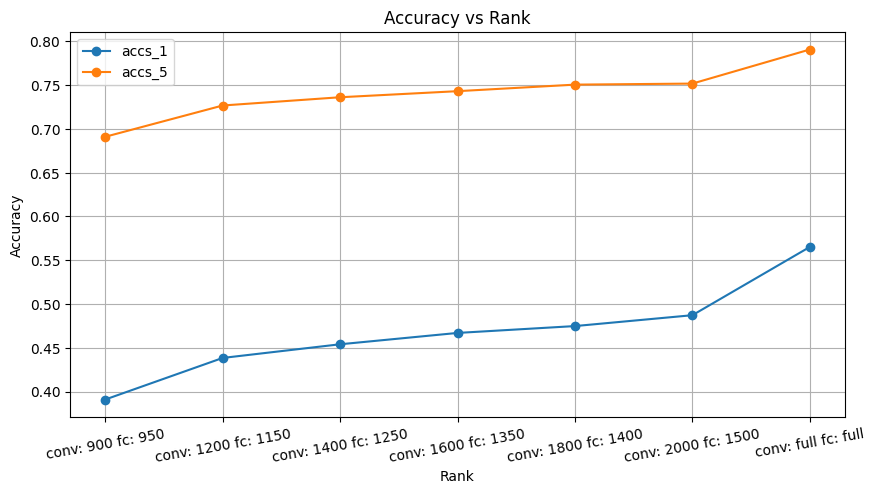

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(ranks, accs_1, marker="o", label="accs_1")
plt.plot(ranks, accs_5, marker="o", label="accs_5")

plt.xlabel("Rank")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Rank")
plt.xticks(rotation=10)
plt.legend()
plt.grid()

plt.savefig("figures/alexnet_accuracy_vs_rank.png")
plt.show()

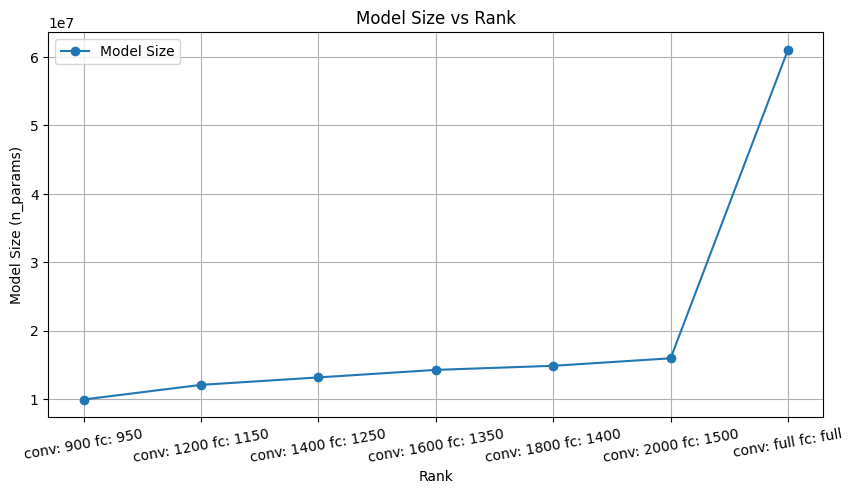

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(ranks, model_sizes, marker="o", label="Model Size")

plt.xlabel("Rank")
plt.ylabel("Model Size (n_params)")
plt.title("Model Size vs Rank")
plt.xticks(rotation=10)
plt.legend()
plt.grid()

plt.savefig("figures/alexnet_model_size_vs_rank.png")
plt.show()

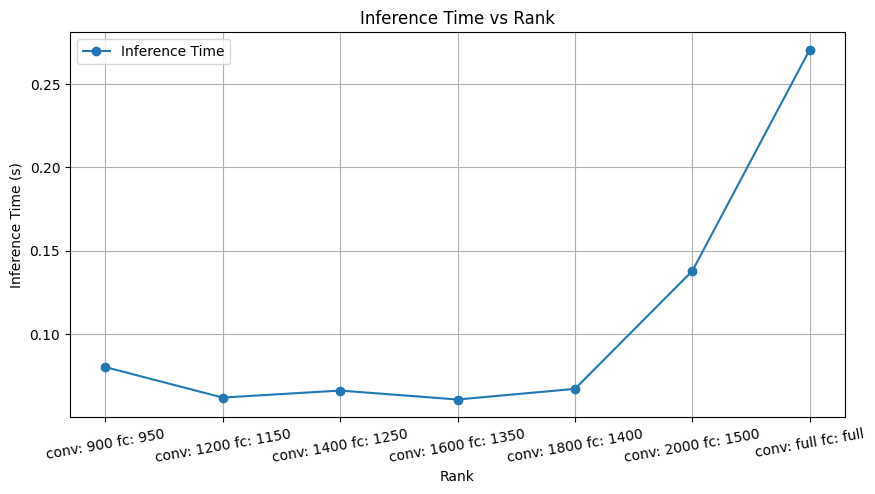

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(ranks, inference_times, marker="o", label="Inference Time")

plt.xlabel("Rank")
plt.ylabel("Inference Time (s)")
plt.title("Inference Time vs Rank")
plt.xticks(rotation=10)
plt.legend()
plt.grid()

plt.savefig("figures/alexnet_inference_time_vs_rank.png")
plt.show()

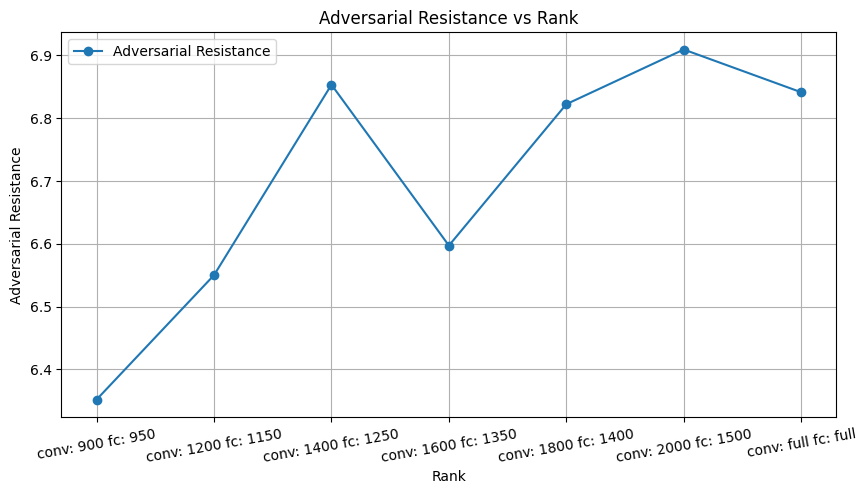

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(ranks, adv_resists, marker="o", label="Adversarial Resistance")

plt.xlabel("Rank")
plt.ylabel("Adversarial Resistance")
plt.title("Adversarial Resistance vs Rank")
plt.xticks(rotation=10)
plt.legend()
plt.grid()

plt.savefig("figures/alexnet_adv_resist_vs_rank.png")
plt.show()